**CIFAR 10 dataset analysis using deep neural networks**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
There are 50000 training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images.

In [0]:
import torch
from torchvision import datasets,transforms
#Normalize data
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])


In [2]:
#now we import training data
trainset=datasets.CIFAR10('~/.pytorch/CIFAR10_data/',download=True,train=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testset=datasets.CIFAR10('~/.pytorch/CIFAR10_data/',download=True,train=False,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

Extracting /root/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10_data/
Files already downloaded and verified


In [0]:
#helper code for displaying images
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="CIFAR10"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "CIFAR10":
        ax2.set_yticklabels(['airplane',
'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

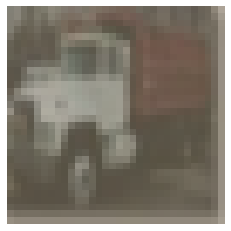

In [49]:
#check images
image,label=next(iter(trainloader));

imshow(image[0,:]);

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images.

In [0]:
#Define model
from torch import nn,optim
import torch.nn.functional as F
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1=nn.Linear(3072,256)
    self.fc2=nn.Linear(256,128)
    self.fc3=nn.Linear(128,64)
    self.fc4=nn.Linear(64,10)
  def forward(self,x):
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x))
    x=F.log_softmax(self.fc4(x),dim=1)
    return x


In [0]:
criterion=nn.CrossEntropyLoss()
model=Classifier()
images,labels=next(iter(trainloader))
images=images.view(images.shape[0],-1)
logits=model(images)
loss=criterion(logits,labels)


In [28]:
print(loss)
optimizer=optim.Adam(model.parameters(),lr=0.005)
train_losses,test_losses=[],[]

tensor(1.4430, grad_fn=<NllLossBackward>)


In [66]:
epochs=20
steps=0
for e in range(epochs):
  running_loss=0
  for images,labels in trainloader:
    optimizer.zero_grad()
    log_ps=model(images)
    loss=criterion(log_ps,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
  else:
    test_loss=0
    accuracy=0

    with torch.no_grad():
      for images,labels in testloader:
        log_ps=model(images)
        test_loss+=criterion(log_ps,labels)
        ps=torch.exp(log_ps)
        top_p,top_class=ps.topk(1,dim=1)
        equals=top_class==labels.view(*top_class.shape)
        accuracy+=torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    print("Epoch: {}/{} ..".format(e+1,epochs),"training_loss: {:.3f}".format(running_loss/len(trainloader)),"test_loss: {:.3f}".format(test_loss/len(testloader)),"test_accuracy: {:.3f}".format(accuracy/len(testloader)))
    

Epoch: 1/20 .. training_loss: 1.129 test_loss: 1.618 test_accuracy: 0.481
Epoch: 2/20 .. training_loss: 1.113 test_loss: 1.592 test_accuracy: 0.495
Epoch: 3/20 .. training_loss: 1.094 test_loss: 1.638 test_accuracy: 0.484
Epoch: 4/20 .. training_loss: 1.071 test_loss: 1.614 test_accuracy: 0.501
Epoch: 5/20 .. training_loss: 1.035 test_loss: 1.646 test_accuracy: 0.499
Epoch: 6/20 .. training_loss: 1.055 test_loss: 1.716 test_accuracy: 0.496
Epoch: 7/20 .. training_loss: 1.020 test_loss: 1.654 test_accuracy: 0.508
Epoch: 8/20 .. training_loss: 1.017 test_loss: 1.606 test_accuracy: 0.508
Epoch: 9/20 .. training_loss: 0.994 test_loss: 1.694 test_accuracy: 0.494
Epoch: 10/20 .. training_loss: 0.992 test_loss: 1.638 test_accuracy: 0.507
Epoch: 11/20 .. training_loss: 0.956 test_loss: 1.704 test_accuracy: 0.499
Epoch: 12/20 .. training_loss: 0.937 test_loss: 1.794 test_accuracy: 0.504
Epoch: 13/20 .. training_loss: 0.933 test_loss: 1.703 test_accuracy: 0.501
Epoch: 14/20 .. training_loss: 0.9

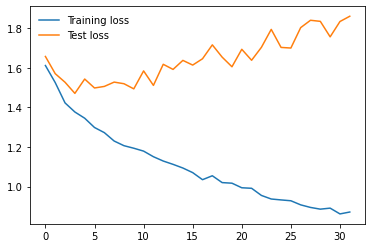

In [67]:
%matplotlib inline 
%config Inline.Backend.figure_format='retina'
import matplotlib.pyplot as plt
plt.plot(train_losses,label='Training loss');
plt.plot(test_losses,label='Test loss');
plt.legend(frameon=False)


torch.Size([3, 32, 32])


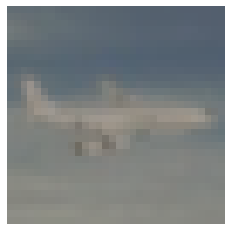

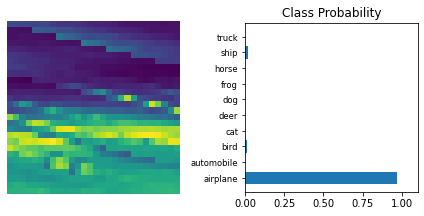

In [82]:
model.eval()
dataiter=iter(testloader)
images,labels=dataiter.next()
img=images[0]
imshow(img);
print(img.shape)
img=img.view(1,3072)

with torch.no_grad():
  output=model.forward(img)


ps=torch.exp(output)
view_classify(img.view(3,32,32),ps,version='CIFAR10')